## 6.1 매개변수 갱신
### 6.1.2 확률적 경사 하강법(SGD)
이때까지 앞에서 사용한 방식.

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 6.1.4 모멘텀
<strong>SGD의 비효율적인 움직임을 부드럽게 만들어 조금 더 효율적으로 움직이도록 하는 v항(속도, velocity)을 추가한 방식.</strong><br><br>
v <- a * v - lr * (dL/dW)<br>
W <- W + v

In [2]:
import numpy as np

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

            for key in params.keys():
                self.v[key] = self.momentum * self.v[key] - self.lr * grads[key] # v <- alpha * v - lr * (dL/dW)
                params[key] += self.v[key] # W <- W + v

### 6.1.5 AdaGrad
<strong>학습을 진행하면서 학습률을 점차 줄여가는 방식.</strong><br><br>
h <- h + (dL/dW) ** 2 (원소 별로 각각 제곱 해줌.)<br>
W <- W - lr * (dL/dW) * (1/sqrt(h))

In [12]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        self.params = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] *  grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
optimization = AdaGrad()

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)

    optimization.update(network.params, grads)

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % 100 == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


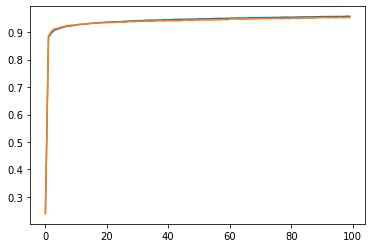

In [22]:
import matplotlib.pyplot as plt

x = np.arange(0, 100)
y1 = train_acc_list
y2 = test_acc_list
y3 = train_loss_list

plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [ ]:
W1, b1, W2, b2 = network.params["W1"], network.params["b1"], network.params["W2"], network.params["b2"]

batch_mask = np.random.choice(x_test.shape[0], 100)
x_batch, t_batch = x_test[batch_mask], t_test[batch_mask]

y = network.predict(x_batch)

for i in range(y.size):
    print(y[i], t_batch[i])

### 6.1.6 Adam
Momentum + AdaGrad

In [ ]:
#교재에 코드 없음.

## 6.2 가중치의 초깃값

### 6.2.2 은닉층의 활성화값 분포

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from common.functions import *

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z


for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

## 6.4 바른 학습을 위해
### 6.4.3 드롭아웃
뉴런을 임의로 삭제하면서 학습하는 방식.

In [51]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # x와 형상이 같은 배열을 무작위 생성. dropout_ratio보다 크면 True, 아니면 False.
            return x * self.mask
        
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

## 6.5 적절한 하이퍼파라미터 값 찾기
### 6.5.1 검증 데이터

In [52]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]